# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None) 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import time

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer #mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from numpy.random import RandomState

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from sklearn.preprocessing import OrdinalEncoder
from lightgbm import LGBMRegressor

from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
# загрузим датасет и рассмотрим первые 5 строк таблицы
try:
    data=pd.read_csv('/datasets/autos.csv')
except:
    data=pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Рассмотрим общую информацию о датасете

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)


In [3]:
data.info()
print('\n','*'*50)
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [4]:
# Оценим полноту данных
mis_columns = data.columns[:21] 
print('Процент незаполненных ячеек в столбцах:')
print()
for mis_columns in data.columns:
    pct_missing = np.mean(data[mis_columns].isnull())
    if pct_missing != 0:
        
        print('{} - {}%'.format(mis_columns, round(pct_missing*100,2)))

Процент незаполненных ячеек в столбцах:

VehicleType - 10.58%
Gearbox - 5.6%
Model - 5.56%
FuelType - 9.28%
Repaired - 20.08%


In [5]:
# проверим на наличие полных дубликотов
data.duplicated().sum()


4

In [6]:
# удалим полные дубли
data = data.drop_duplicates()
data.duplicated().sum()

0

В представленном датасете 354369 строк и 16 столбцов
В ряде столбцов есть пропуски.
Средняя стоимость автомобиля 4416 евро
Минимальный год регистриции автомобиля 1000, максимальный - 9999.
Минимальная мощность автомобиля в лошадинных силах - 20 000. 
Минимальный пробег авто 5000, максимальный - 150000, но при этом много авто имееют максимальный пробег. Это может быть каким-то из заданных значений в форме заполнения.

Больше всего пропусков в столбце о ремонте авто.
Часть признаков выглядят неинформативными, удалим их для дальнейшей работы.

### Удалим неинформативные признаки

In [7]:
# проверила про год выгрузки 
data.DateCrawled.max()

'2016-04-07 14:36:58'

In [8]:
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated','NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


### Описательные функции

In [9]:
#чтобы избежать повторяющихся действий создадим функцию для описания столбцов
def description(column):
    print('наименование столбца:',column)
    print('тип данных:', data[column].dtypes)
    print('пропущенно значений:',data[column].isna().sum())
    if data[column].dtypes == 'object':
        print('уникальные значения:', '\n', data[column].value_counts())
    else:
        print('минимальное значение:',data[column].min())
        print('максимальное значение:', data[column].max())

In [10]:
# функция для визуализации распределения числовых стобцов
def vizual (column, column_name):

    sns.displot(x = column, legend=True, kde=True, height=5.7, aspect=1.5, bins=100)
    plt.title('Распределение значений признака ' + str(column_name).title(), fontsize=16)

    plt.figure(figsize=((10,5)))
    sns.boxplot(y=column)

In [11]:
# функция для визуализации распределения категориальных столбцов
def make_plotbar(index, title):
    
    pivot = pd.DataFrame(data.pivot_table(index=index, aggfunc="size").sort_values(ascending=False)).head(15)
    pivot.columns = ['count']
    plt.figure(figsize=(12,6))
    plt.title(title)
    
    sns.barplot(x='count', y=pivot.index, data=pivot)

In [12]:
# функция для заполнения пропусков в категориальных столбцах модой
def fill_by_mode(column, column_1, column_2):
    data[column] = data.groupby([column_1, column_2])[column]\
    .transform(lambda x: x.fillna((x.mode()[0] if not x.mode()\
                                   .empty else "unknown")))

### Предобработка данных

#### Рассмотрим категориальные признаки

наименование столбца: Brand
тип данных: object
пропущенно значений: 0
уникальные значения: 
 volkswagen        77012
opel              39931
bmw               36914
mercedes_benz     32044
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2322
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover              

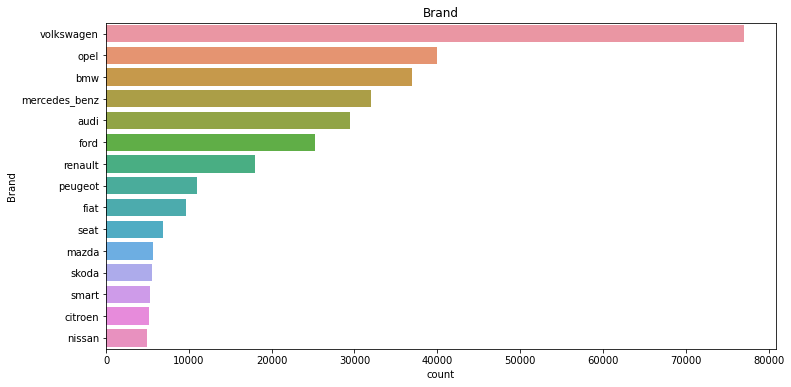

In [13]:
description('Brand')
make_plotbar('Brand', 'Brand')

наименование столбца: Model
тип данных: object
пропущенно значений: 19705
уникальные значения: 
 golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 250, dtype: int64


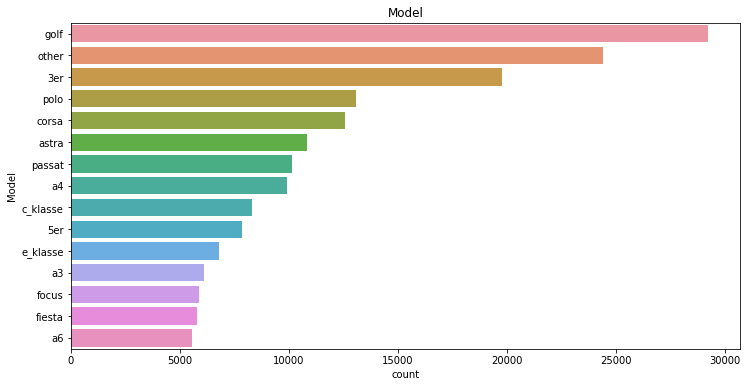

In [14]:
description('Model')
make_plotbar('Model', 'Model')

In [15]:
fill_by_mode('Model', 'Brand', 'RegistrationYear')
description('Model')

наименование столбца: Model
тип данных: object
пропущенно значений: 0
уникальные значения: 
 golf                  32689
other                 25895
3er                   21641
corsa                 13887
polo                  13066
                      ...  
i3                        8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 251, dtype: int64


In [16]:
data['Model'] = data['Model'].replace('unknown', 'other')

наименование столбца: VehicleType
тип данных: object
пропущенно значений: 37490
уникальные значения: 
 sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64


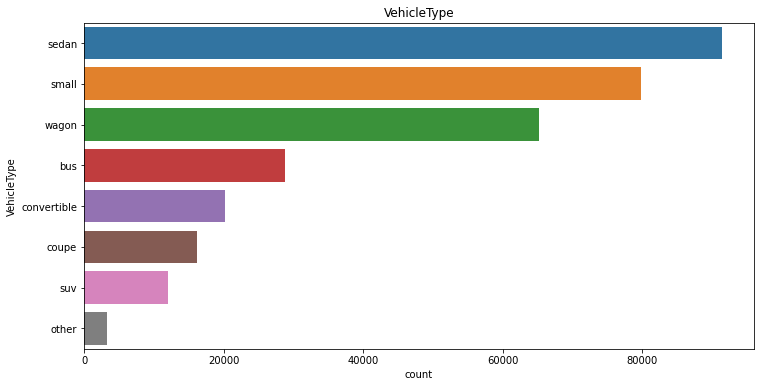

In [17]:
description('VehicleType')
make_plotbar('VehicleType', 'VehicleType')

In [18]:
fill_by_mode('VehicleType', 'Brand', 'Model')   
description('VehicleType')

наименование столбца: VehicleType
тип данных: object
пропущенно значений: 0
уникальные значения: 
 sedan          108358
small           91051
wagon           69159
bus             32415
convertible     20487
coupe           16832
suv             12746
other            3317
Name: VehicleType, dtype: int64


Отнесем 4 неизвестных типа кузова к категории other.

наименование столбца: Gearbox
тип данных: object
пропущенно значений: 19833
уникальные значения: 
 manual    268249
auto       66283
Name: Gearbox, dtype: int64


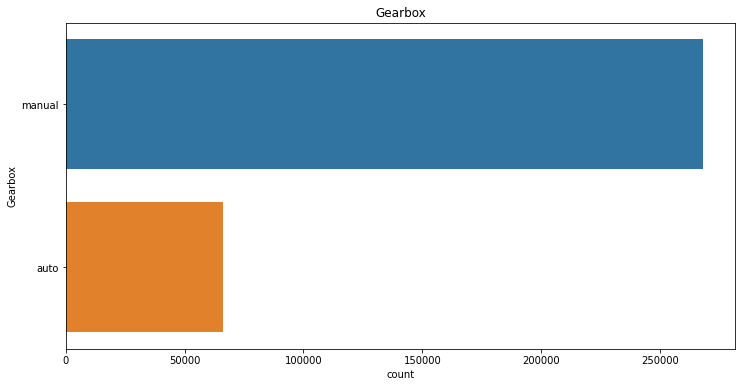

In [19]:
description('Gearbox')
make_plotbar('Gearbox', 'Gearbox')

In [20]:
fill_by_mode('Gearbox', 'Brand', 'Model') 
description('Gearbox')

наименование столбца: Gearbox
тип данных: object
пропущенно значений: 0
уникальные значения: 
 manual    285949
auto       68416
Name: Gearbox, dtype: int64


наименование столбца: FuelType
тип данных: object
пропущенно значений: 32895
уникальные значения: 
 petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64


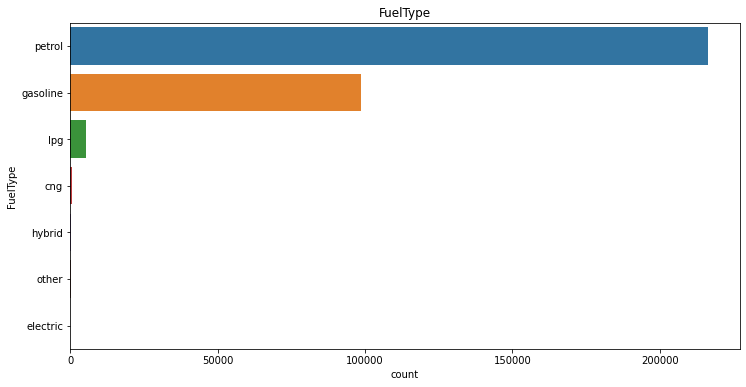

In [21]:
description('FuelType')
make_plotbar('FuelType', 'FuelType')

In [22]:
fill_by_mode('FuelType', 'Brand', 'Model') 
description('FuelType')

наименование столбца: FuelType
тип данных: object
пропущенно значений: 0
уникальные значения: 
 petrol      243903
gasoline    104060
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64


petrol и gasoline - это названия бензина в разных странах. Приведем их к общему виду.

In [23]:
data['FuelType'] = data['FuelType'].replace('gasoline', 'petrol')

#### Расмотрим численные показатели

наименование столбца: Price
тип данных: int64
пропущенно значений: 0
минимальное значение: 0
максимальное значение: 20000


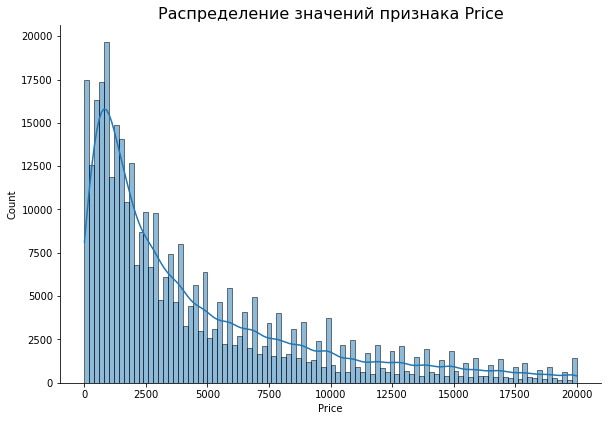

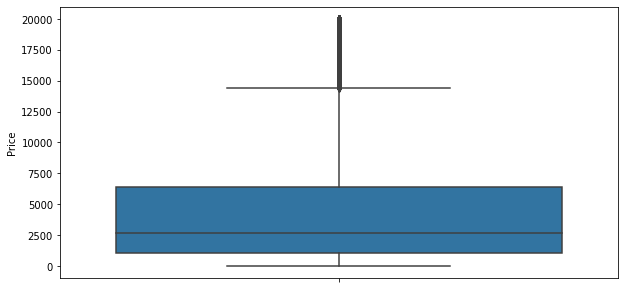

In [24]:
description('Price')
vizual(data['Price'], 'Price')

Минимальное значение - 0. Посмотрим сколько авто собираются отдать даром.

In [25]:
data[data['Price'].values == 0 ]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,small,1990,manual,0,corsa,150000,petrol,opel,NaN
111,0,sedan,2017,manual,0,golf,5000,petrol,volkswagen,NaN
115,0,small,1999,manual,0,golf,5000,petrol,volkswagen,NaN
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354205,0,small,2000,manual,65,corsa,150000,petrol,opel,yes
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,NaN
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,NaN
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


In [26]:
data[data['Price'].values < 100 ]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,small,1990,manual,0,corsa,150000,petrol,opel,NaN
59,1,suv,1994,manual,286,other,150000,petrol,sonstige_autos,NaN
89,1,sedan,1995,manual,113,e_klasse,150000,petrol,mercedes_benz,no
111,0,sedan,2017,manual,0,golf,5000,petrol,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,NaN
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,NaN
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes
354309,99,small,1999,manual,60,arosa,150000,petrol,seat,yes


Бесплатно отдают 10772 авто. Принимая во внимание, то  остальные данные по авто  более-менее заполненны.  Так же есть авто, цена на которые сосавляет менее 100 евро , что подозрительно мало даже для авто в очень плохом состоянии.  Поэтому заменим 0 на медианную стоимость по Бренду и Модели. И удалим значения менее 100 евро.

In [27]:
data['Price'] = data['Price'].replace(0, np.nan)
median = data.groupby(['Brand'])['Price'].transform('median')
data['Price'] = data['Price'].fillna(median)

In [28]:
data = data.query('Price > 101')

In [29]:
# Приводим в целочисленный тип 
data['Price'] = data['Price'].astype(int)

In [30]:
#проверка
description('Price')

наименование столбца: Price
тип данных: int64
пропущенно значений: 0
минимальное значение: 105
максимальное значение: 20000


наименование столбца: RegistrationYear
тип данных: int64
пропущенно значений: 0
минимальное значение: 1000
максимальное значение: 9999


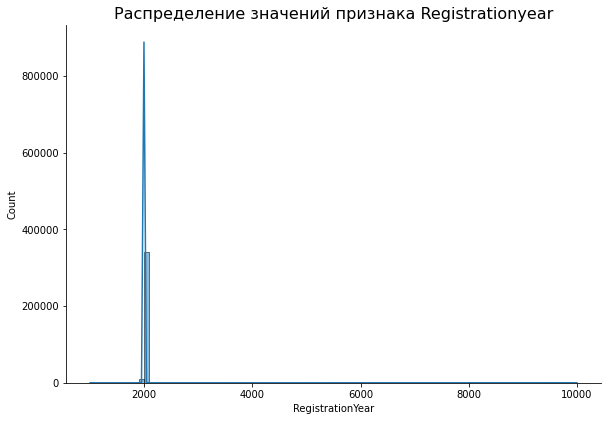

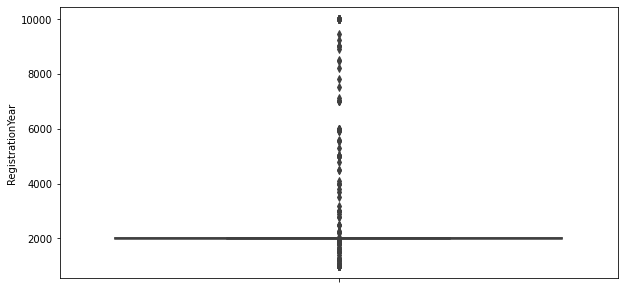

In [31]:
description('RegistrationYear')
vizual(data['RegistrationYear'], 'RegistrationYear')

In [32]:
data[data['RegistrationYear'].values > 2022 ]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
15147,4200,sedan,9999,manual,0,other,10000,petrol,sonstige_autos,NaN
15870,1700,sedan,3200,manual,0,other,5000,petrol,sonstige_autos,NaN
17271,700,suv,9999,manual,0,other,10000,petrol,opel,NaN
17346,6500,sedan,8888,manual,0,other,10000,petrol,sonstige_autos,NaN
18259,300,small,2200,manual,0,twingo,5000,petrol,renault,NaN
...,...,...,...,...,...,...,...,...,...,...
328453,450,wagon,2500,manual,0,6_reihe,5000,petrol,mazda,NaN
333488,4999,sedan,9999,manual,0,3er,10000,petrol,bmw,NaN
334967,12000,sedan,4000,manual,500,golf,5000,petrol,volkswagen,no
335727,8299,small,7500,manual,0,other,10000,petrol,mini,no


In [33]:
data[data['RegistrationYear'].values < 1886 ].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
622,1600,suv,1111,manual,0,other,5000,petrol,opel,NaN
16062,190,wagon,1000,manual,0,mondeo,5000,petrol,ford,NaN
18224,7999,sedan,1500,manual,224,impreza,5000,petrol,subaru,NaN
34332,450,bus,1800,manual,1800,other,5000,petrol,mitsubishi,no
38875,1234,sedan,1234,manual,26,other,5000,petrol,trabant,NaN


Учитывая, что 1886 -  год изобретения авто, а 2023 текущий год, и видя, что авто зарегистированных ранее 1886 и позднее 2023: 5 и 90 строк соответсвенно, а остальные данные в этих строках практически не заполненны - удалим аномальные значения.

In [34]:
data = data.query('RegistrationYear > 1886 & RegistrationYear < 2017')

In [35]:
# прверим
description('RegistrationYear')

наименование столбца: RegistrationYear
тип данных: int64
пропущенно значений: 0
минимальное значение: 1910
максимальное значение: 2016


Есть гипотеза, что для разных возрастов машин - своё ценообразование. Введем фактор "тип возраста".

Сформируем группы:
- раритет (1910 - 1940)
- ретро (1941 - 1970)
- страрая (1971 - 2000)
- новая (2001 - 2016)

In [36]:
def age (value):
    if 1910 <= value < 1940:
        return "раритет"
    if 1941 <= value < 1970:
        return "ретро"
    elif 1971 <= value < 2000:
        return "страрая"
    elif 2001  <= value <= 2016:
        return "новая"
 
data['Age'] = data['RegistrationYear'].map(age)
display(data.head())

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Age
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,NaN,страрая
1,18300,coupe,2011,manual,190,a4,125000,petrol,audi,yes,новая
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,NaN,новая
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,новая
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no,новая


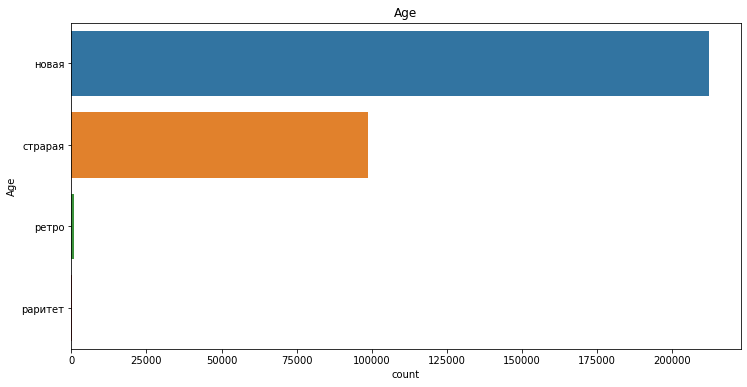

In [37]:
make_plotbar('Age', 'Age')

наименование столбца: Power
тип данных: int64
пропущенно значений: 0
минимальное значение: 0
максимальное значение: 20000


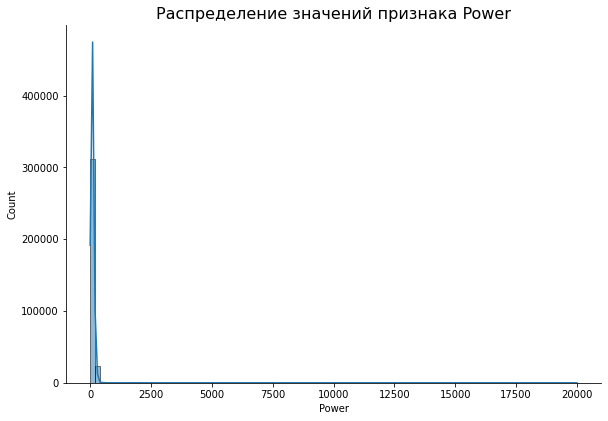

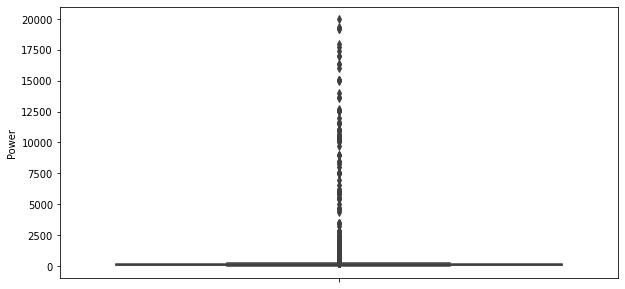

In [38]:
description('Power')
vizual(data['Power'], 'Power')

Максимальная мощность автомобиля 1600 лс, и это мощность гоночных балидов. 

In [39]:
data[data['Power'].values > 1600 ]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Age
2102,1600,sedan,1999,manual,1799,vectra,150000,petrol,opel,yes,страрая
7661,1499,small,1999,manual,7515,lupo,150000,petrol,volkswagen,NaN,страрая
9664,2599,bus,2016,manual,1779,zafira,150000,petrol,opel,no,новая
9875,550,wagon,2003,manual,1753,focus,150000,petrol,ford,yes,новая
11039,1600,sedan,1998,manual,10317,other,150000,petrol,fiat,no,страрая
...,...,...,...,...,...,...,...,...,...,...,...
346639,1300,sedan,2000,manual,12512,carisma,150000,petrol,mitsubishi,NaN,None
348006,355,sedan,1998,manual,1799,vectra,150000,petrol,opel,NaN,страрая
348137,850,sedan,1993,auto,9012,golf,150000,petrol,volkswagen,NaN,страрая
348237,3000,coupe,2007,manual,2007,corsa,150000,petrol,opel,yes,новая


In [40]:
data = data.query('Power < 1601')

In [41]:
data['Power'] = data['Power'].replace(0, np.nan)
median = data.groupby(['Brand'])['Price'].transform('median')
data['Power'] = data['Power'].fillna(median)

наименование столбца: Power
тип данных: float64
пропущенно значений: 0
минимальное значение: 1.0
максимальное значение: 11999.0


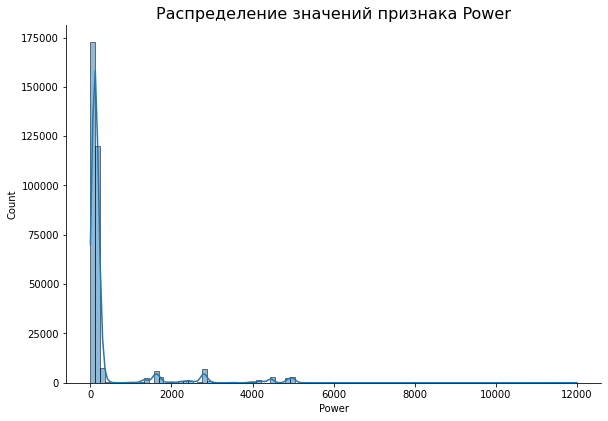

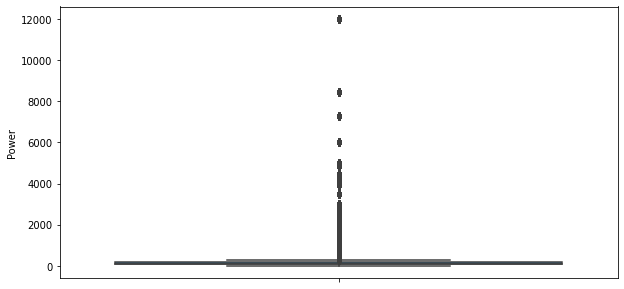

In [42]:
description('Power')
vizual(data['Power'], 'Power')

Мы видим подозрительный всплес в районе 1350 л.с. вероятно это какое-то значение предлагаемой как автозаполение. Думаю мы можем удалить все значения выше 400 л.с. и мнее 50.

In [43]:
data = data.query('Power < 401 & Power > 49')

In [44]:
# Приводим в целочисленный тип 
data['Power'] = data['Power'].astype(int)
#проверка
description('Power')

наименование столбца: Power
тип данных: int64
пропущенно значений: 0
минимальное значение: 50
максимальное значение: 400


наименование столбца: Kilometer
тип данных: int64
пропущенно значений: 0
минимальное значение: 5000
максимальное значение: 150000


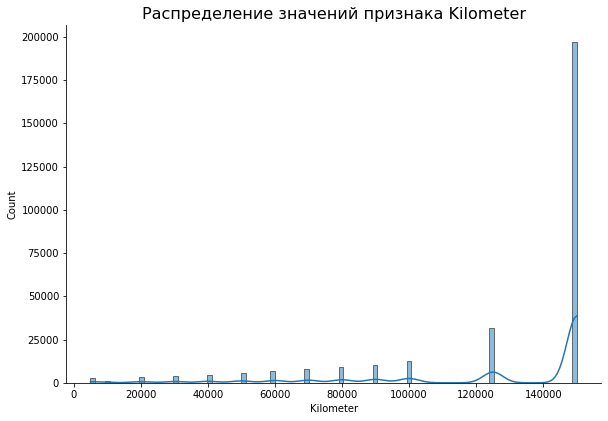

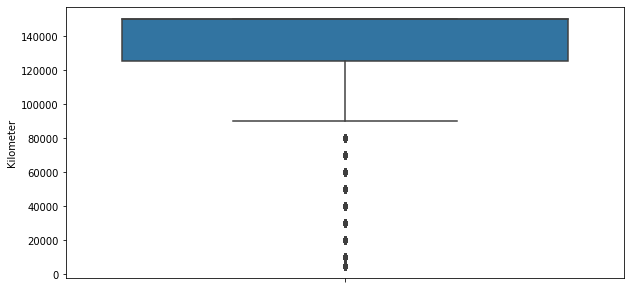

In [45]:
description('Kilometer')
vizual(data['Kilometer'], 'Kilometer')

In [46]:
data[data['Kilometer'].values == 150000 ]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Age
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,новая
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,страрая
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,новая
9,999,small,1998,manual,101,golf,150000,petrol,volkswagen,NaN,страрая
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no,новая
...,...,...,...,...,...,...,...,...,...,...,...
354359,7900,sedan,2010,manual,140,golf,150000,petrol,volkswagen,no,новая
354361,5250,wagon,2016,auto,150,159,150000,petrol,alfa_romeo,no,новая
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes,новая
354367,9200,bus,1996,manual,102,transporter,150000,petrol,volkswagen,no,страрая


Наиболее популярное заданое значение 150 000, вероятно именно это число предлагается в шаблоне автозаполнения. Из 306 312 строк датасета в 205 045 стоит значение 150 000. Предлагаю удалить этот столбец как не информативный.

In [47]:
data = data.drop(['Kilometer'], axis=1)
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,FuelType,Brand,Repaired,Age
1,18300,coupe,2011,manual,190,a4,petrol,audi,yes,новая
2,9800,suv,2004,auto,163,grand,petrol,jeep,NaN,новая
3,1500,small,2001,manual,75,golf,petrol,volkswagen,no,новая
4,3600,small,2008,manual,69,fabia,petrol,skoda,no,новая
5,650,sedan,1995,manual,102,3er,petrol,bmw,yes,страрая


наименование столбца: Repaired
тип данных: object
пропущенно значений: 43184
уникальные значения: 
 no     223237
yes     28890
Name: Repaired, dtype: int64


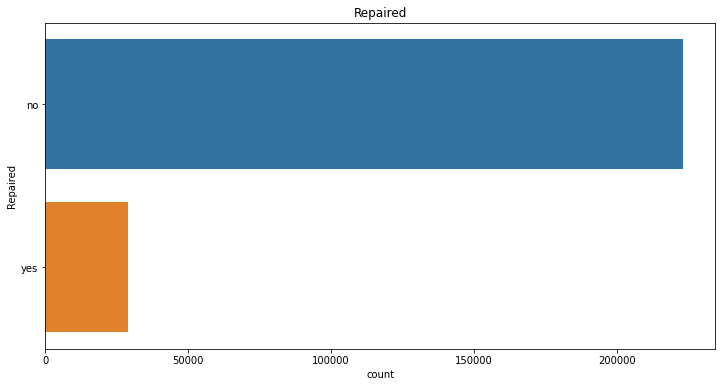

In [48]:
description('Repaired')
make_plotbar('Repaired', 'Repaired')

Пропуски образуюи третью категорию, когда нам неизвестно была ли машина в ремонте. Переведем признак в числовой для удобства, где:
0 - отсутствие ремонта,
1 - неизвестно был ли ремонт,
2 - ремонт был

In [49]:
data['Repaired'] = data['Repaired'].fillna(1)

def not_repaired(value):
    if value == 'no':
        return 0
    elif value == 'yes':
        return 2
    else:
        return value

data['Repaired'] = data['Repaired'].apply(not_repaired)
data['Repaired'].value_counts()

0    223237
1     43184
2     28890
Name: Repaired, dtype: int64

#### Рассмотри корреляцию между показателями.

In [50]:
data.corr()

,Price,RegistrationYear,Power,Repaired
Price,1.000000,0.494260,0.501319,-0.256776
RegistrationYear,0.494260,1.000000,0.107524,-0.138264
Power,0.501319,0.107524,1.000000,-0.073504
Repaired,-0.256776,-0.138264,-0.073504,1.000000


In [51]:
! pip install phik
import phik
from phik import resources, report
# get the phi_k correlation matrix between all variables
data.phik_matrix()

     |████████████████████████████████| 679 kB 1.9 MB/s eta 0:00:01
interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Repaired']


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,FuelType,Brand,Repaired,Age
Price,1.000000,0.260442,0.460429,0.326471,0.508339,0.573144,0.045268,0.364875,0.328183,0.493329
VehicleType,0.260442,1.000000,0.157776,0.282365,0.498191,0.915769,0.071751,0.631584,0.093248,0.214043
RegistrationYear,0.460429,0.157776,1.000000,0.058121,0.132349,0.571338,0.080338,0.295653,0.249157,0.875366
Gearbox,0.326471,0.282365,0.058121,1.000000,0.591417,0.637651,0.099843,0.518901,0.024976,0.109830
Power,0.508339,0.498191,0.132349,0.591417,1.000000,0.792524,0.089662,0.573727,0.103071,0.174549
Model,0.573144,0.915769,0.571338,0.637651,0.792524,1.000000,0.318805,0.997991,0.228529,0.466970
FuelType,0.045268,0.071751,0.080338,0.099843,0.089662,0.318805,1.000000,0.188685,0.031684,0.035318
Brand,0.364875,0.631584,0.295653,0.518901,0.573727,0.997991,0.188685,1.000000,0.129985,0.294776
Repaired,0.328183,0.093248,0.249157,0.024976,0.103071,0.228529,0.031684,0.129985,1.000000,0.125403
Age,0.493329,0.214043,0.875366,0.109830,0.174549,0.466970,0.035318,0.294776,0.125403,1.000000


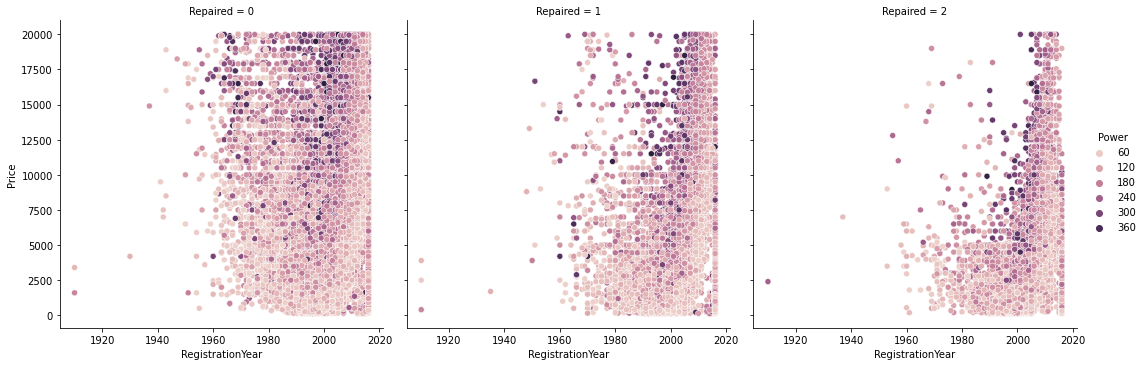

In [52]:
sns.relplot(
    data=data,
    x='RegistrationYear',
    y='Price',
    col='Repaired',
    hue='Power');

Наибольшая корреляция целевого признака (цена) прослеживается с параметром мощности, обратная зависимость с параметром - ремонт. Однако, показатели достаточно малы, для того чтобы мы могли утвержать о наличии стойкой линейной зависимости.  

Сбросим индексы

In [53]:
data = data.reset_index(drop=True)

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295311 entries, 0 to 295310
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             295311 non-null  int64 
 1   VehicleType       295311 non-null  object
 2   RegistrationYear  295311 non-null  int64 
 3   Gearbox           295311 non-null  object
 4   Power             295311 non-null  int64 
 5   Model             295311 non-null  object
 6   FuelType          295311 non-null  object
 7   Brand             295311 non-null  object
 8   Repaired          295311 non-null  int64 
 9   Age               276292 non-null  object
dtypes: int64(4), object(6)
memory usage: 22.5+ MB


ВЫВОД:

В представленном датасете 354369 строк и 16 столбцов. 

После обработки пропусков и аномальных значений, часть из них была заполненна медианами по аналогичным столбцам, часть-признанна невозможоной к востановлению и удалена.

После обработки в датасете сохранилось:305777 строк и 10 столбцов.

На последнем этапе предобработки данных была проанализированна корреляция между показателями. Наибольшая корреляция целевого признака (цена) прослеживается с параметром мощности, обратная зависимость с параметром - ремонт. Однако, показатели достаточно малы, для того чтобы мы могли утвержать о наличии стойкой линейной зависимости.

## Обучение моделей

###  Подготовка данных
#### Преобразование признаков
Для того, чтобы преобразовать категориальные признаки в численные, вызовем функцию get_dummies() с аргументом drop_first. Такой подход позволит не попасть в дамми-ловушку, так как не создает большое количество фиктивных признаков.

In [55]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head()

,Price,RegistrationYear,Power,Repaired,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Age_раритет,Age_ретро,Age_страрая
0,18300,2011,190,2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,

#### Разбиение данных на выборки
Разделим исходные данные на три выборки: обучающую (60%), валидационную (20%) и тестовую (20%). 

In [56]:
STATE = 123

In [57]:
target = data_ohe['Price']
features = data_ohe.drop('Price', axis=1)

In [58]:
features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              train_size=0.60, 
                                                                              test_size=0.40, 
                                                                              random_state=STATE)

In [59]:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            train_size=0.50, 
                                                                            test_size=0.50, 
                                                                            random_state=STATE)

In [60]:
# оценим размеры
for _ in [features_train,features_valid, features_test, target_train,target_valid, target_test]:
    print(_.shape)

(177186, 306)
(59062, 306)
(59063, 306)
(177186,)
(59062,)
(59063,)


####  Масштабирование признаков
Приведем признаки к одному масштабу. Для этого будем использовать структуру для стандартизации данных StandardScaler.

In [61]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

Для оценки качества моделей будем применять метрику RMSE. Для простоты расчетов содадим функцию.

In [62]:
#функция для вычисления  RMSE:
def rmse(target, predicted):
    return mse(target, predicted) ** 0.5

### Обучение моделей

#### Oбучим простые модели

In [63]:
# модели
model_dt = DecisionTreeRegressor()
model_lr = LinearRegression()

##### Работа с DecisionTreeRegressor моделью

In [64]:
# зададим параметры для моделей
score = make_scorer(rmse, greater_is_better = False) 

parameters_dt = {'max_depth':[x for x in range(2,12,3)],
                'min_samples_leaf':[x for x in range(2,12,3)],
                'random_state':[STATE]}
parameters_lr = {'normalize': [False]}

results = []

In [65]:
%%time
# перебор гипперпараметров и обучение модели
# DecisionTreeRegressor
grid_dt = GridSearchCV(model_dt, parameters_dt, cv=5, scoring =score ) 
grid_dt = grid_dt.fit(features_train, target_train)


CPU times: user 3min 51s, sys: 8.96 s, total: 4min
Wall time: 4min 1s


In [66]:
grid_dt.best_params_

{'max_depth': 11, 'min_samples_leaf': 11, 'random_state': 123}

In [67]:
model_dt = DecisionTreeRegressor(max_depth=11, min_samples_leaf=11, random_state = STATE)
start = time.time() 
model_dt = model_dt.fit(features_train, target_train)
end_time_fit = time.time() - start

In [68]:
start = time.time() 
predictions_dt = model_dt.predict(features_valid)
end_time_predict = time.time() - start

In [69]:
results.append({'Модель': 'DecisionTreeRegressor', 
                'Параметры':{'max_depth':11, 'min_samples_leaf': 11, 'random_state': STATE}, 
                'Время обучения': end_time_fit, 
                'Скорость предсказания': end_time_predict, 
                'RMSE': rmse(target_valid, predictions_dt)})

pd.DataFrame(results)

,Модель,Параметры,Время обучения,Скорость предсказания,RMSE
0,DecisionTreeRegressor,"{'max_depth': 11, 'min_samples_leaf': 11, 'ran...",2.465613,0.058346,2013.646688


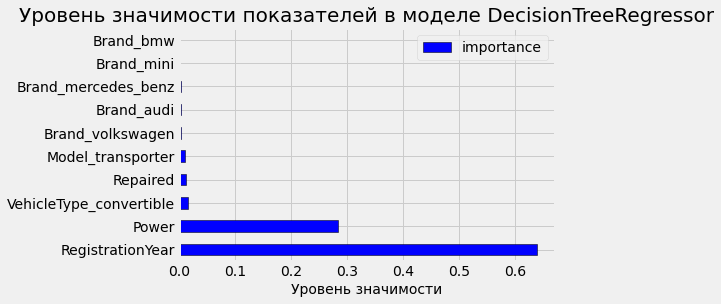

In [70]:
importances_dt = model_dt.feature_importances_
feature_list = list(features)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances_dt})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

feature_results.head(10)

#figsize(12, 10)
plt.style.use('fivethirtyeight')

feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Уровень значимости', size = 14); plt.ylabel('')
plt.title('Уровень значимости показателей в моделе DecisionTreeRegressor', size = 20);

##### Работа с LinearRegression моделью

In [71]:
#%%time
# перебор гипперпараметров и обучение модели
#LinearRegression
#grid_lr = GridSearchCV(model_lr,parameters_lr,cv=5,scoring =score)
#start = time.time() 
#model_lr = model_lr.fit(features_train, target_train)
#end_time_fit = time.time() - start

CPU times: user 9.36 s, sys: 4.81 s, total: 14.2 s
Wall time: 14.4 s


In [72]:
#Обучим модель LinearRegression
model_lr = LinearRegression(normalize = False)
start = time.time() 
model_lr = model_lr.fit(features_train, target_train)
end_time_fit = time.time() - start

In [73]:
start = time.time() 
predictions_lr = model_lr.predict(features_valid)
end_time_predict = time.time() - start

In [74]:
results.append({'Модель': 'LinearRegression', 
                'Параметры': parameters_lr, 
                'Время обучения': end_time_fit, 
                'Скорость предсказания': end_time_predict, 
                'RMSE': rmse(target_valid, predictions_lr)})

pd.DataFrame(results)

,Модель,Параметры,Время обучения,Скорость предсказания,RMSE
0,DecisionTreeRegressor,"{'max_depth': 11, 'min_samples_leaf': 11, 'ran...",2.465613,0.058346,2013.646688
1,LinearRegression,{'normalize': [False]},14.026675,0.015949,2848.185323


Для модели LinearRegression Факторы важности отсутствуют, т.к. модель не использует в своей работе ветвление деревьев

#### Библиотеки для градиентного бустинг

Для работы были выбраны CatBoostRegression и LGBMRegressor

-  Возьмем датасет data
-  Отскалируем числовые признаки 
-  Для работы LGBMRegressor обработаем категориальные признаки с помощью OrdinalEncoding 
-  Обучим LGBMRegressor 
-  Для работы CatBoostRegression обработаем категориальные признаки с помощью LabelEncoder
-  Обучим CatBoostRegression

In [75]:
category_features = ['VehicleType', 'Gearbox', 'Brand', 'Model', 'FuelType','Age']

number_features = ['RegistrationYear', 'Power', 'Repaired']


In [76]:
target = data['Price']
features = data.drop('Price', axis=1)

# Разделим выборку на тренировочную и валидационную
features_train_b, features_valid_b, target_train_b, target_valid_b = train_test_split(features, 
                                                                              target, 
                                                                              train_size=0.60, 
                                                                              test_size=0.40, 
                                                                              random_state=STATE)
# Разделим выборку на валидационную и тестовую
features_valid_b, features_test_b, target_valid_b, target_test_b = train_test_split(features_valid_b, 
                                                                            target_valid_b, 
                                                                            train_size=0.50, 
                                                                            test_size=0.50, 
                                                                            random_state=STATE)


In [77]:
# Проведем скалирование
scaler.fit(features_train_b[number_features])
features_train_b[number_features] = scaler.transform(features_train_b[number_features])
features_valid_b[number_features] = scaler.transform(features_valid_b[number_features])
features_test_b[number_features] = scaler.transform(features_test_b[number_features])

In [78]:
# Дополнительно обработаем категориальные признаки

#features_train_gbm = features_train_b.copy()
#features_valid_gbm = features_valid_b.copy()
#features_test_gbm = features_test_b.copy()

#category_features_gbm = ['VehicleType', 'Gearbox', 'Brand', 'Model', 'FuelType']

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(features_train_b[category_features])
features_train_b[category_features] = encoder.transform(features_train_b[category_features])
features_valid_b[category_features] = encoder.transform(features_valid_b[category_features])
features_test_b[category_features] = encoder.transform(features_test_b[category_features])


##### Работа с LGBMRegressor моделью

In [79]:
best_RMSE = 2500
best_n_estimator = 0
best_num_leaves = 0
best_end_time_fit = 0
best_end_time_predict = 0

for n_estimator in range(20, 61, 20):
    
    for num_leaves in range(20, 41, 10):
        model_lgb = LGBMRegressor(boosting_type='gbdt', verbose=0, seed=STATE,force_row_wise= True)
    
        start = time.time() 
        model_lgb.fit(features_train_b, target_train_b)
        end_time_fit = time.time() - start

        start = time.time() 
        predictions_lgb = model_lgb.predict(features_valid_b, verbose=1)
        end_time_predict = time.time() - start

        RMSE = rmse(target_valid_b, predictions_lgb)
        
        if RMSE < best_RMSE:
            best_RMSE = RMSE
            best_n_estimator = n_estimator
            best_num_leaves = num_leaves
            best_end_time_fit = end_time_fit
            best_end_time_predict = end_time_predict

In [80]:
print(best_RMSE, best_n_estimator, best_num_leaves , best_end_time_fit, best_end_time_predict)

1822.8670487583172 20 20 3.5921058654785156 0.5075266361236572


In [81]:
results.append({'Модель': 'LGBMRegressor', 
                'Параметры': {'random_state':STATE, 
                              'n_estimator': best_n_estimator, 
                              'num_leaves': best_num_leaves, 
                              }, 
                'Время обучения': best_end_time_fit, 
                'Скорость предсказания':best_end_time_predict, 
                'RMSE': best_RMSE})

In [82]:
pd.DataFrame(results)

,Модель,Параметры,Время обучения,Скорость предсказания,RMSE
0,DecisionTreeRegressor,"{'max_depth': 11, 'min_samples_leaf': 11, 'ran...",2.465613,0.058346,2013.646688
1,LinearRegression,{'normalize': [False]},14.026675,0.015949,2848.185323
2,LGBMRegressor,"{'random_state': 123, 'n_estimator': 20, 'num_...",3.592106,0.507527,1822.867049


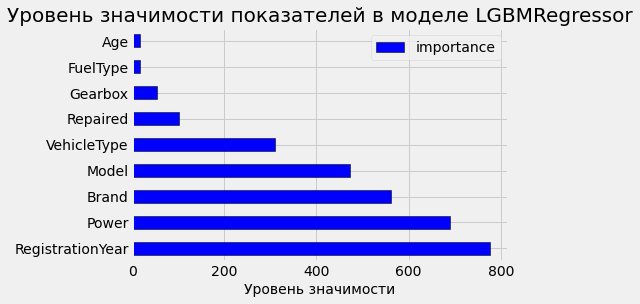

In [83]:
importances_lgb = model_lgb.feature_importances_
feature_list = list(features)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances_lgb})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

feature_results.head(10)

plt.style.use('fivethirtyeight')

feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Уровень значимости', size = 14); plt.ylabel('')
plt.title('Уровень значимости показателей в моделе LGBMRegressor', size = 20);

##### Работа с CatBoostRegression моделью

In [85]:
best_RMSE = 2500
best_iteration = 0
best_depth = 0
best_end_time_fit = 0
best_end_time_predict = 0

for iteration in range(10, 101, 20):
    
    for depth in range(5, 11, 2):
        model_cbr = CatBoostRegressor(random_state=STATE, iterations=iteration,\
                                          loss_function='RMSE', depth=depth)
    
        start = time.time() 
        model_cbr.fit(features_train_b, target_train_b)
        end_time_fit = time.time() - start

        start = time.time() 
        predictions_cbr = model_cbr.predict(features_valid_b, verbose=1)
        end_time_predict = time.time() - start

        RMSE = rmse(target_valid_b, predictions_cbr)
        
        if RMSE < best_RMSE:
            best_RMSE = RMSE
            best_iteration = iteration
            best_depth = depth
            best_end_time_fit = end_time_fit
            best_end_time_predict = end_time_predict

Learning rate set to 0.5
0:	learn: 3294.0828841	total: 71.8ms	remaining: 647ms
1:	learn: 2725.0636545	total: 94ms	remaining: 376ms
2:	learn: 2481.9739504	total: 115ms	remaining: 268ms
3:	learn: 2354.0677504	total: 135ms	remaining: 202ms
4:	learn: 2267.3673065	total: 156ms	remaining: 156ms
5:	learn: 2212.9155377	total: 175ms	remaining: 117ms
6:	learn: 2171.0845492	total: 196ms	remaining: 84.2ms
7:	learn: 2131.6854321	total: 217ms	remaining: 54.4ms
8:	learn: 2105.8139442	total: 240ms	remaining: 26.6ms
9:	learn: 2090.9225506	total: 260ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3215.0756918	total: 26ms	remaining: 234ms
1:	learn: 2626.8988587	total: 52.8ms	remaining: 211ms
2:	learn: 2359.3088350	total: 76.3ms	remaining: 178ms
3:	learn: 2227.2594330	total: 101ms	remaining: 151ms
4:	learn: 2154.4491632	total: 125ms	remaining: 125ms
5:	learn: 2092.0139094	total: 152ms	remaining: 101ms
6:	learn: 2068.8539989	total: 174ms	remaining: 74.7ms
7:	learn: 2040.3074546	total: 195ms	remaining:

In [86]:
print(best_RMSE, best_iteration, best_depth , best_end_time_fit, best_end_time_predict)

1776.1460988427534 90 9 3.6639554500579834 0.018094539642333984


In [87]:
results.append({'Модель': 'CatBoostRegressor', 
                'Параметры': {'random_state':STATE, 
                              'iterations': best_iteration, 
                              'loss_function': 'RMSE', 
                              'depth': best_depth}, 
                'Время обучения': best_end_time_fit, 
                'Скорость предсказания':best_end_time_predict, 
                'RMSE': best_RMSE})

In [88]:
pd.DataFrame(results)

,Модель,Параметры,Время обучения,Скорость предсказания,RMSE
0,DecisionTreeRegressor,"{'max_depth': 11, 'min_samples_leaf': 11, 'ran...",2.465613,0.058346,2013.646688
1,LinearRegression,{'normalize': [False]},14.026675,0.015949,2848.185323
2,LGBMRegressor,"{'random_state': 123, 'n_estimator': 20, 'num_...",3.592106,0.507527,1822.867049
3,CatBoostRegressor,"{'random_state': 123, 'iterations': 90, 'loss_...",3.663955,0.018095,1776.146099


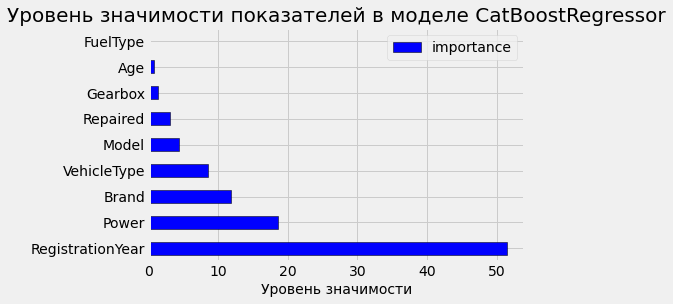

In [89]:
importances_cbr = model_cbr.feature_importances_
feature_list = list(features)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances_cbr})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

feature_results.head(10)

plt.style.use('fivethirtyeight')

feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Уровень значимости', size = 14); plt.ylabel('')
plt.title('Уровень значимости показателей в моделе CatBoostRegressor', size = 20);

Для всех заявленных в работу моделей подобранны наилушие параметры. Перейдем к анализу результатов.

## Анализ моделей

In [90]:
pd.DataFrame(results).style.highlight_min(color = 'lightblue', axis = 0)

,Модель,Параметры,Время обучения,Скорость предсказания,RMSE
0,DecisionTreeRegressor,"{'max_depth': 11, 'min_samples_leaf': 11, 'random_state': 123}",2.465613,0.058346,2013.646688
1,LinearRegression,{'normalize': [False]},14.026675,0.015949,2848.185323
2,LGBMRegressor,"{'random_state': 123, 'n_estimator': 20, 'num_leaves': 20}",3.592106,0.507527,1822.867049
3,CatBoostRegressor,"{'random_state': 123, 'iterations': 90, 'loss_function': 'RMSE', 'depth': 9}",3.663955,0.018095,1776.146099


Наилучший результат RMSE показывает модель CatBoostRegressor (1773.61).

Наилучшая скорость предсказания у этой же модели с гиперпараметрами iterations = 90 и depth = 9. 

Наилучшее время обучения у модели DecisionTreeRegressor с гиперпараметрами max_depth = 11, min_samples_leaf = 11, хотя качество предсказаний нижу чем у LGBMRegressor и CatBoostRegressor, оно все еще не привышает заданный порог метрики в 2500.

Хуже всего себя показала модеть LinearRegression, у нее наибольшая скорость обучения и показатель RMSE не проходящий порог пригодности.

Так как заказчику важны все 3 параметра - качество предсказания, скорость предсказания и время обучения остановим выбор на моделе CatBoostRegressor. Она превосходит остальные подели по 2 параметрам из 3. А по времени обучения занимает 2-е место, лишь немного уступая DecisionTreeRegressor.

In [91]:
model_final = CatBoostRegressor(random_state= STATE, iterations=90, loss_function='RMSE', depth=9)

start = time.time() 
model_final.fit(features_train_b, target_train_b)
end_time_fit = time.time() - start
print('Время обучения(fit):', end_time_fit)

start = time.time() 
predictions_final = model_final.predict(features_test_b)
end_time_predict = time.time() - start
print('Скорость предсказания(predict):', end_time_predict)

print('RMSE :', rmse(target_test_b, predictions_final))

Learning rate set to 0.5
0:	learn: 3146.2559220	total: 36.5ms	remaining: 3.25s
1:	learn: 2541.9357453	total: 67.1ms	remaining: 2.95s
2:	learn: 2265.9767089	total: 97.1ms	remaining: 2.81s
3:	learn: 2139.7680148	total: 125ms	remaining: 2.69s
4:	learn: 2069.0376327	total: 155ms	remaining: 2.64s
5:	learn: 2015.2450024	total: 186ms	remaining: 2.61s
6:	learn: 1981.8251205	total: 214ms	remaining: 2.54s
7:	learn: 1958.5549003	total: 244ms	remaining: 2.5s
8:	learn: 1933.9903128	total: 273ms	remaining: 2.46s
9:	learn: 1924.5965620	total: 302ms	remaining: 2.41s
10:	learn: 1911.2273452	total: 336ms	remaining: 2.41s
11:	learn: 1899.6178055	total: 365ms	remaining: 2.37s
12:	learn: 1888.7208383	total: 395ms	remaining: 2.34s
13:	learn: 1879.0559796	total: 424ms	remaining: 2.3s
14:	learn: 1869.5153088	total: 458ms	remaining: 2.29s
15:	learn: 1864.7991067	total: 488ms	remaining: 2.26s
16:	learn: 1860.7641113	total: 521ms	remaining: 2.23s
17:	learn: 1854.3886666	total: 552ms	remaining: 2.21s
18:	learn: 1

Проверим модель на адекватность.

In [92]:
dummy_regr = DummyRegressor(strategy='mean')

dummy_regr.fit(features_train_b, target_train_b)
predictions_r_dummy = dummy_regr.predict(features_test_b)
print('RMSE dummy:', rmse(target_test_b, predictions_r_dummy))

RMSE dummy: 4577.956786996687



В представленном датасете 354369 строк и 16 столбцов В ряде столбцов есть пропуски. Средняя стоимость автомобиля 4416 евро Минимальный год регистриции автомобиля 1000, максимальный - 9999. Минимальная мощность автомобиля в лошадинных силах - 20 000. Минимальный пробег авто 5000, максимальный - 150000, но при этом много авто имееют максимальный пробег. Это может быть каким-то из заданных значений в форме заполнения.
Больше всего пропусков в столбце о ремонте авто. Часть признаков выглядят неинформативными, удалим их для дальнейшей работы.

После обработки пропусков и аномальных значений, часть из них была заполненна медианами по аналогичным столбцам, часть-признанна невозможоной к востановлению и удалена.
После обработки в датасете сохранилось:305777 строк и 10 столбцов.
    
На последнем этапе предобработки данных была проанализированна корреляция между показателями.
Наибольшая корреляция целевого признака (цена) прослеживается с параметром мощности, обратная зависимость с параметром - ремонт. Однако, показатели достаточно малы, для того чтобы мы могли утвержать о наличии стойкой линейной зависимости. 
    
Для обучения были выбранны 4 модели:
    
- DecisionTreeRegressor
- LinearRegression
- LGBMRegressor
- CatBoostRegression
    
Наилучшие результат RMSE и скорость  показала модель CatBoostRegressor.
Наилучшее время обучения  -  DecisionTreeRegressor.
Хуже всего себя показала модеть LinearRegression, у нее наибольшая скорость обучения и показатель RMSE не проходящий заданный заказчиком порог пригодности.
    
Так как заказчику важны все 3 параметра - качество предсказания, скорость предсказания и время обучения была выбранна модель CatBoostRegressor. Она превосходит остальные подели по 2 параметрам из 3. А по времени обучения занимает 2-е место, лишь немного уступая DecisionTreeRegressor.
    
При проверке CatBoostRegressor на тестовой выботке показатель RMSE составил 1768, что немногим хуже поведения модели на тренировочных данных и попрежнему проходит порог прегодности в 2500.
